In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 24
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

WL=0
WW=1000

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = "scse"

#### head

In [7]:
ACT = None
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "sgd"
init_lr = 3e-4
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR

In [10]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    mse_l = 0
    ssim_l = 0
    mae_l = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, *_ = data

        x = x.to(device)
        y = y.to(device)

        y_pr = model(x)
        
        _mse = nn.MSELoss()(y_pr.float(), y.float())
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)

        _loss = _mse + _ssim + _mae
                        
        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        mse_l += _mse.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mse_l/(index+1), mae_l/(index+1), ssim_l/(index+1)

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = []
    psnr_ = []
    for index, data in tqdm(enumerate(dataloader)):

        _, _, *hu_bins = data

        for i in range(0, len(hu_bins), 2):
            x = hu_bins[i]
            y = hu_bins[i+1]
        
            x = x.to(device)
            y = y.to(device)

            y_pr = model(x)
        
            _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(y_pr, y, 1.0)

            ssim_ += [_ssim.item()]
            psnr_ += [_psnr.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_)

In [28]:
@torch.no_grad()
def test_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim = 0
    psnr = 0
    for index, data in tqdm(enumerate(dataloader)):

        _, _, *hu_bins = data

        
        for i in range(0, len(hu_bins), 2):
            x = hu_bins[i]
            y = hu_bins[i+1]
        
            x = x.to(device)
            y = y.to(device)

            y_pr = model(x)
            
            x = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            y = (y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            print(torch.max(y_pr), torch.min(y_pr))
            
            y_pr = (y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)

            for b in range(x.shape[0]):
                visualize(
                    cbct = x[b, :, :],
                    ct_y = y[b, :, :],
                    ct_pred = y_pr[b, :, :],
                )


# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [14]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=None, geometry_aug=aug.get_validation_augmentation())

In [16]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f2fec48f9a0>,)

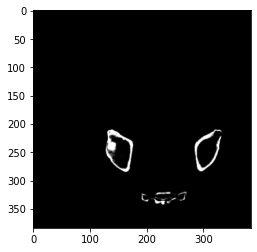

In [18]:
plt.imshow(x.squeeze(), 'gray'),

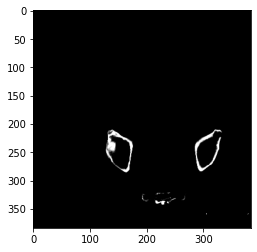

In [19]:
plt.imshow(y.squeeze(), 'gray')

In [20]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [21]:
import wandb

wandb.init(project="cbct", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
        "decoder_attention_type": DECODER_ATT
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [22]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [23]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)

In [24]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr, momentum=momentum)

In [25]:
wandb.watch(model)

max_ssim = 0

for epoch in range(EPOCH):
        
        loss_mse, loss_mae, loss_ssim = train_epoch(model, optimizer, trainloader, device)
        score_ssim_train, score_psnr_train = eval_epoch(model, trainloader, device)
        score_ssim_test, score_psnr_test = eval_epoch(model, testloader, device)

        
        wandb.log({
            "mse loss": loss_mse,
            "ssim loss": loss_ssim,
            "mae loss": loss_mae,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test
        })
        
        
        if score_ssim_test > max_ssim:
            max_ssim = score_ssim_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

56it [00:53,  1.06it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.69s/it]
8it [00:13,  1.72s/it]
56it [00:51,  1.08it/s]
56it [01:34,  1.68s/it]
8it [00:13,  1.72s/it]
56it [

In [ ]:
test_epoch(model, testloader, device)

In [ ]:
test_epoch(model, trainloader, device)